# Imports 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from dictionary import column_mapping
import textwrap

sns.set_theme()

# 4. Modelling

In [2]:
df = pd.read_csv("../../../databases/q1_database.csv")
df = df.drop(columns=["Avg Reading Result"])
df.sample(5)

,Avg Math Result,BMMJ1,CNT_Group,CREATOOS,ESCS,FAMCON,HISEI,HOMEPOS,IC171Q02JA,IC173Q04JA,...,ST289Q02JA,ST289Q05WA,ST289Q06JA,ST289Q10WA,ST290Q01WA,ST290Q02WA,ST290Q03WA,ST290Q05WA,ST291Q01JA,ST355Q02JA
370741,485.1858,NaN,Below Average,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
430730,426.3577,57.03,Above Average,4.3051,0.2267,4.2992,57.03,-0.3359,NaN,NaN,...,NaN,5.0,NaN,NaN,4.0,NaN,NaN,NaN,3.0,NaN
350567,311.1819,17.00,Below Average,4.4186,-0.8795,NaN,17.69,-0.5944,NaN,NaN,...,NaN,2.0,1.0,1.0,2.0,NaN,2.0,NaN,NaN,NaN
66082,427.4253,51.50,Average,-0.8105,-0.0118,-2.3650,51.50,-0.6525,4.0,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,2.0,NaN,NaN,3.0
182391,408.8154,NaN,Above Average,-0.8105,-0.0073,0.5977,NaN,-0.6840,NaN,NaN,...,NaN,3.0,NaN,NaN,3.0,3.0,NaN,3.0,3.0,NaN


In [3]:
y = df["Avg Math Result"]
X = df.drop(columns=["Avg Math Result"])

repeat_col = X["REPEAT"]
X = X.drop(columns=["REPEAT"])

### Pre-process

In [4]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

numerical_transformer = Pipeline(
    [("imputer", SimpleImputer(strategy="mean")), ("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    [
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols),
    ]
)

X_encoded = preprocessor.fit_transform(X)

onehot_columns = preprocessor.named_transformers_["cat"][
    "onehot"
].get_feature_names_out(categorical_cols)
final_columns = list(numerical_cols) + list(onehot_columns)


X_encoded_df = pd.DataFrame(X_encoded, columns=final_columns)

X_encoded_df["REPEAT"] = repeat_col.reset_index(drop=True)

X_encoded_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 1].drop(columns=["REPEAT"])
X_encoded_not_repeating = X_encoded_df[X_encoded_df["REPEAT"] == 0].drop(
    columns=["REPEAT"]
)

### K-means

In [5]:
kmeans_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_repeating)
kmeans_not_repeating = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(X_encoded_not_repeating)

In [6]:
repeating = df[df["REPEAT"] == 1].reset_index(drop=True)
repeating["kmeans"] = kmeans_repeating.labels_
X_encoded_repeating["kmeans"] = kmeans_repeating.labels_

not_repeating = df[df["REPEAT"] == 0].reset_index(drop=True)
not_repeating["kmeans"] = kmeans_not_repeating.labels_
X_encoded_not_repeating["kmeans"] = kmeans_not_repeating.labels_

print(repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())
print(not_repeating.groupby("kmeans")["Avg Math Result"].describe().to_string())

          count        mean        std       min         25%        50%         75%       max
kmeans                                                                                       
0       12082.0  348.688187  59.561334  122.8485  306.382700  341.74345  384.130575  661.8582
1       27562.0  399.065672  86.056714   97.6254  334.370125  390.61020  453.875400  763.4544
2       20108.0  323.481965  51.646285   39.1713  290.204850  318.80540  352.623250  636.7595
           count        mean        std       min         25%       50%         75%       max
kmeans                                                                                       
0       217455.0  427.887344  73.245294  105.7688  375.064300  424.4471  476.263250  776.9333
1       110462.0  370.076523  63.497353  121.7875  325.901425  363.1559  407.212375  759.3522
2       179907.0  524.622476  83.578745  189.7535  469.300000  526.5810  581.517000  843.2881


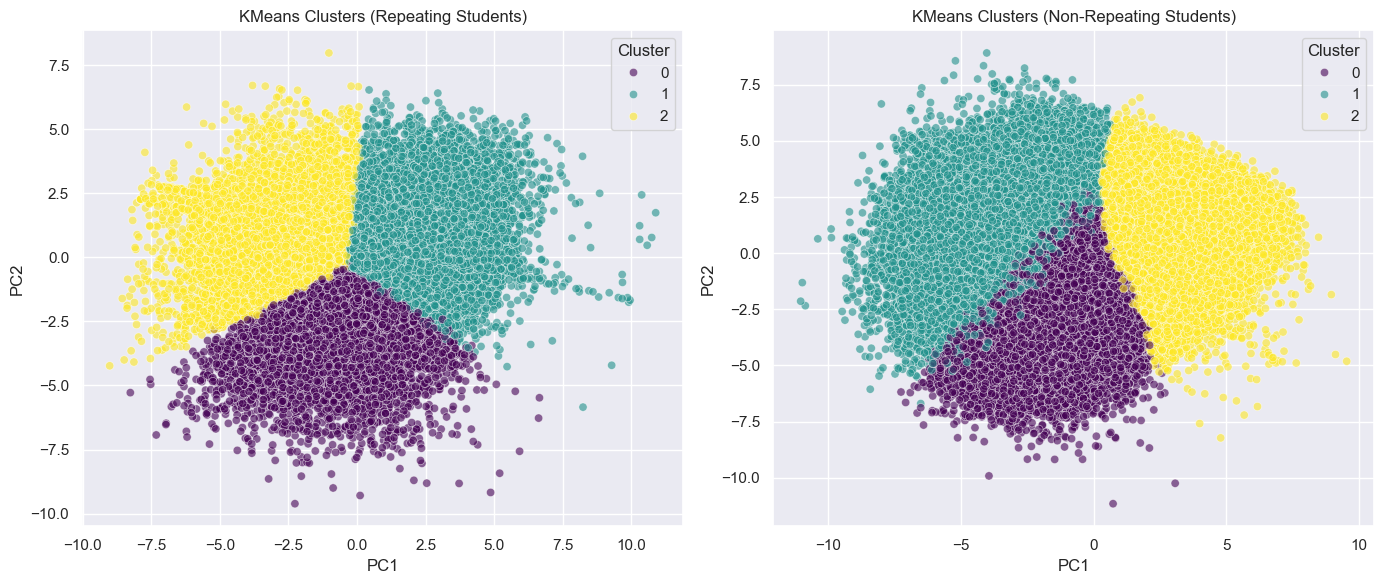

In [7]:
# repeating pca
pca_repeating = PCA(n_components=2)
X_pca_repeating = pca_repeating.fit_transform(X_encoded_repeating)
X_pca_repeating_df = pd.DataFrame(X_pca_repeating, columns=["PC1", "PC2"])
X_pca_repeating_df["Cluster"] = kmeans_repeating.labels_

# not repeating pca
pca_not_repeating = PCA(n_components=2)
X_pca_not_repeating = pca_not_repeating.fit_transform(X_encoded_not_repeating)
X_pca_not_repeating_df = pd.DataFrame(X_pca_not_repeating, columns=["PC1", "PC2"])
X_pca_not_repeating_df["Cluster"] = kmeans_not_repeating.labels_

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    data=X_pca_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.scatterplot(
    data=X_pca_not_repeating_df,
    x="PC1",
    y="PC2",
    hue="Cluster",
    palette="viridis",
    alpha=0.6,
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")
plt.tight_layout()
plt.show()

Ordenar os módulos por média:

In [8]:
means = repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels = means.sort_values().index.tolist()

label_map = {old_label: new_label for new_label, old_label in enumerate(ordered_labels)}

repeating["kmeans"] = repeating["kmeans"].map(label_map)
X_encoded_repeating["kmeans"] = X_encoded_repeating["kmeans"].map(label_map)

means_nonrep = not_repeating.groupby("kmeans")["Avg Math Result"].mean()
ordered_labels_nonrep = means_nonrep.sort_values().index.tolist()
label_map_nonrep = {
    old_label: new_label for new_label, old_label in enumerate(ordered_labels_nonrep)
}
not_repeating["kmeans"] = not_repeating["kmeans"].map(label_map_nonrep)
X_encoded_not_repeating["kmeans"] = X_encoded_not_repeating["kmeans"].map(
    label_map_nonrep
)

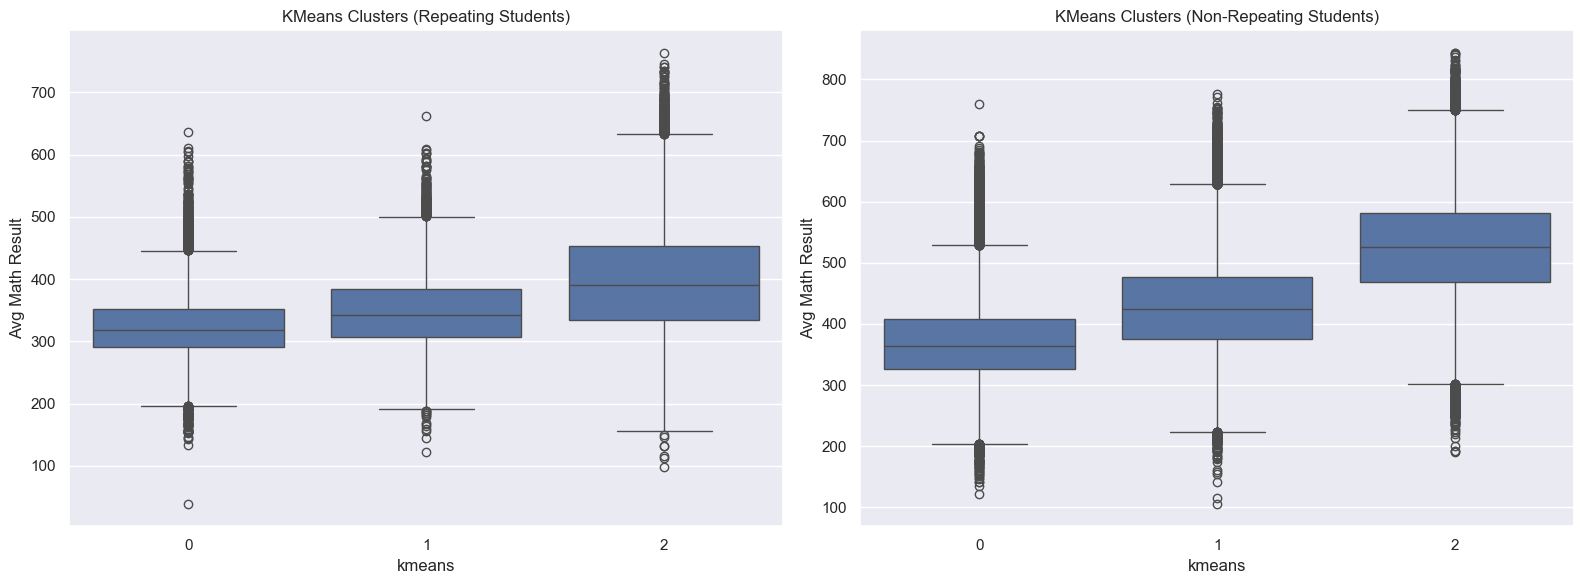

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(
    data=repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[0],
)
axes[0].set_title("KMeans Clusters (Repeating Students)")

sns.boxplot(
    data=not_repeating,
    x="kmeans",
    y="Avg Math Result",
    ax=axes[1],
)
axes[1].set_title("KMeans Clusters (Non-Repeating Students)")

plt.tight_layout()
plt.show()

Boxplots interessantes para além do target 

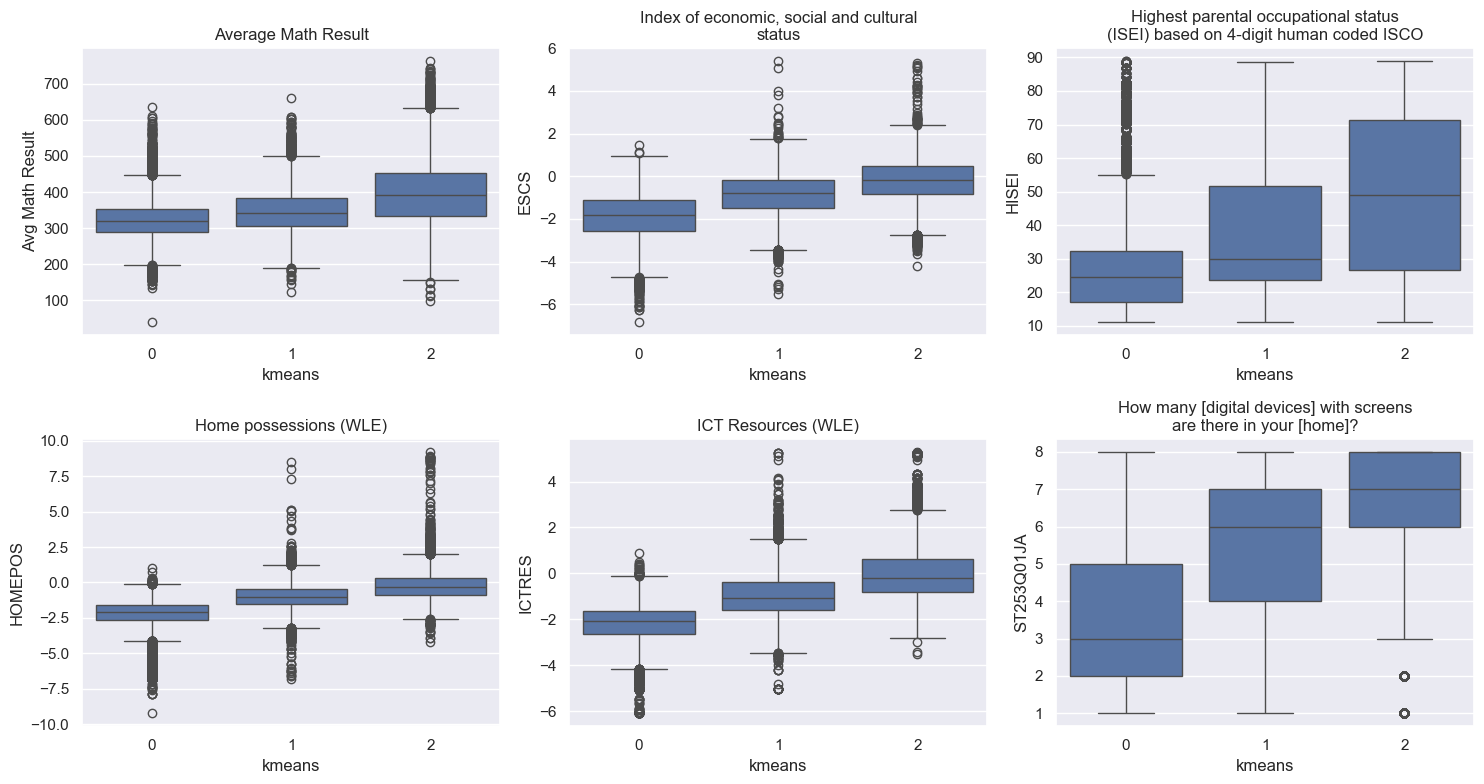

In [10]:
# columns_to_plot = repeating.columns.drop(
#     [
#         "kmeans",
#         "REPEAT",
#         "CNT_Group",
#         "IC177Q07JA",
#         "IC173Q04JA",
#         "CREATOOS",
#         "OECD",
#         "ST250Q02JA",
#         "ST255Q01JA",
#         "ST290Q01WA",
#         "ST290Q02WA",
#         "ST290Q03WA",
#         "ST291Q01JA",
#         "ST256Q03JA",
#         "ST290Q05WA",
#         "ST355Q02JA",
#         "BMMJ1",
#         "ST059Q02JA",
#         "ST251Q06JA",
#         "IC171Q02JA",
#     ]
# )

columns_to_plot = [
    "Avg Math Result",
    "ESCS",
    "HISEI",
    "HOMEPOS",
    "ICTRES",
    "ST253Q01JA",
]

n_cols = 3
n_rows = -(-len(columns_to_plot) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.boxplot(data=repeating, x="kmeans", y=column, ax=axes[i])
    title = column_mapping.get(column, column)
    wrapped_title = "\n".join(textwrap.wrap(title, width=40))
    axes[i].set_title(wrapped_title)
    axes[i].tick_params(axis="x")

for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
centroids_repeating = pd.DataFrame(
    kmeans_repeating.cluster_centers_,
    columns=X_encoded_repeating.drop(columns="kmeans").columns,
)
print(centroids_repeating.to_string())

      BMMJ1  CREATOOS      ESCS    FAMCON     HISEI   HOMEPOS  IC171Q02JA  IC173Q04JA  IC177Q07JA    ICTRES   MATHEFF      OECD  ST059Q02JA  ST250Q02JA  ST251Q06JA  ST253Q01JA  ST255Q01JA  ST256Q03JA  ST289Q02JA  ST289Q05WA  ST289Q06JA  ST289Q10WA  ST290Q01WA  ST290Q02WA  ST290Q03WA  ST290Q05WA  ST291Q01JA  ST355Q02JA  CNT_Group_Above Average  CNT_Group_Average  CNT_Group_Below Average
0 -0.373227  0.222905 -0.460316 -1.170999 -0.442973 -0.436931   -0.575442   -0.365206    0.205941 -0.207883 -1.092213  0.046812   -0.461137    0.100604   -0.258238   -0.335831   -0.543574   -0.389470   -1.127944   -1.113598   -1.160083   -0.820510   -0.769717   -0.712241   -0.750650   -0.850505   -0.741291   -0.424932                 0.417960           0.093348                 0.488693
1 -0.071273  0.117830  0.098368  0.044478 -0.066609  0.200118   -0.025911   -0.005508    0.117564  0.288968  0.135653  0.305014   -0.050915   -0.273224    0.070140    0.192186   -0.052066   -0.088726    0.080839   -0.00117

## Supervised Learning Aproach (Random Forest Classifier)

In [20]:
def plot_feature_importances(importance_df, cluster_id=None, mapping=column_mapping):
    melted_df = importance_df.reset_index().melt(
        id_vars="index", var_name="Group", value_name="Importance"
    )
    melted_df.rename(columns={"index": "Feature"}, inplace=True)

    melted_df["Feature"] = (
        melted_df["Feature"]
        .map(mapping)
        .fillna(melted_df["Feature"])
        .apply(lambda x: "\n".join(textwrap.wrap(x, 60)))
    )

    plt.figure(figsize=(12, 6))
    sns.barplot(data=melted_df, y="Feature", x="Importance", hue="Group")
    if cluster_id is not None:
        plt.title(
            f"Top Feature Importances for Cluster {cluster_id} (Repeating vs Non-Repeating)"
        )
    else:
        plt.title(
            f"Top Feature Importances (Repeating vs Non-Repeating)"
        )
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    plt.legend(title="Group")
    plt.tight_layout()
    plt.show()

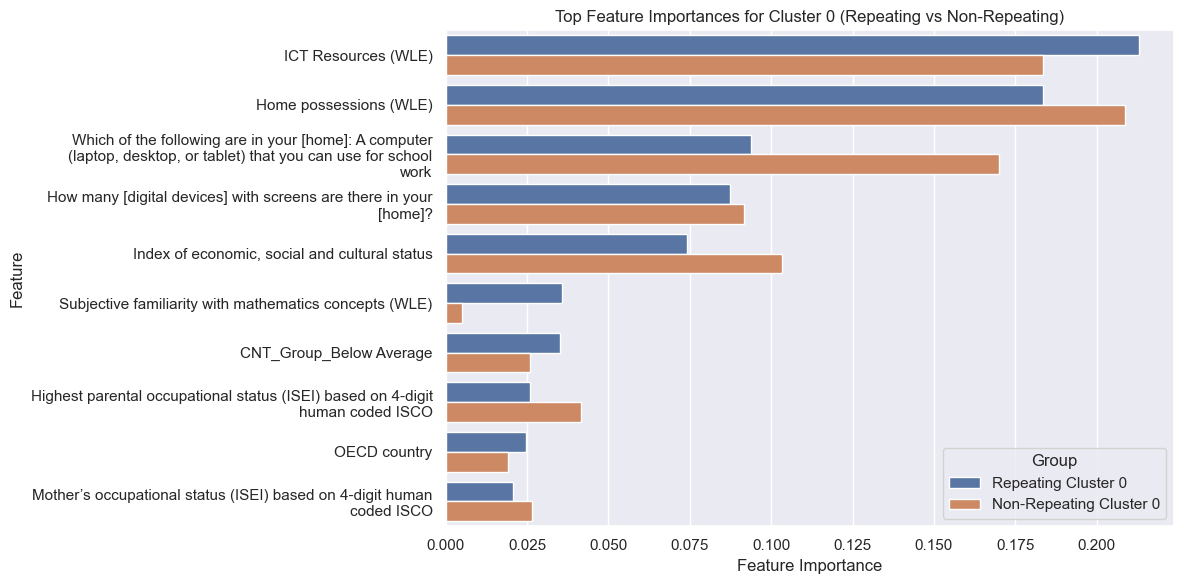

In [13]:
# Cluster 0
X_0_repeating = X_encoded_repeating.copy()
X_0_repeating["cluster_0"] = (X_0_repeating["kmeans"] == 0).astype(int)

X_rep = X_0_repeating.drop(columns=["kmeans", "cluster_0"])
y_rep = X_0_repeating["cluster_0"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_0_not_repeating = X_encoded_not_repeating.copy()
X_0_not_repeating["cluster_0"] = (X_0_not_repeating["kmeans"] == 0).astype(int)

X_nonrep = X_0_not_repeating.drop(columns=["kmeans", "cluster_0"])
y_nonrep = X_0_not_repeating["cluster_0"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 0": importances_rep,
        "Non-Repeating Cluster 0": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 0", ascending=False)

plot_feature_importances(importance_df, cluster_id=0)

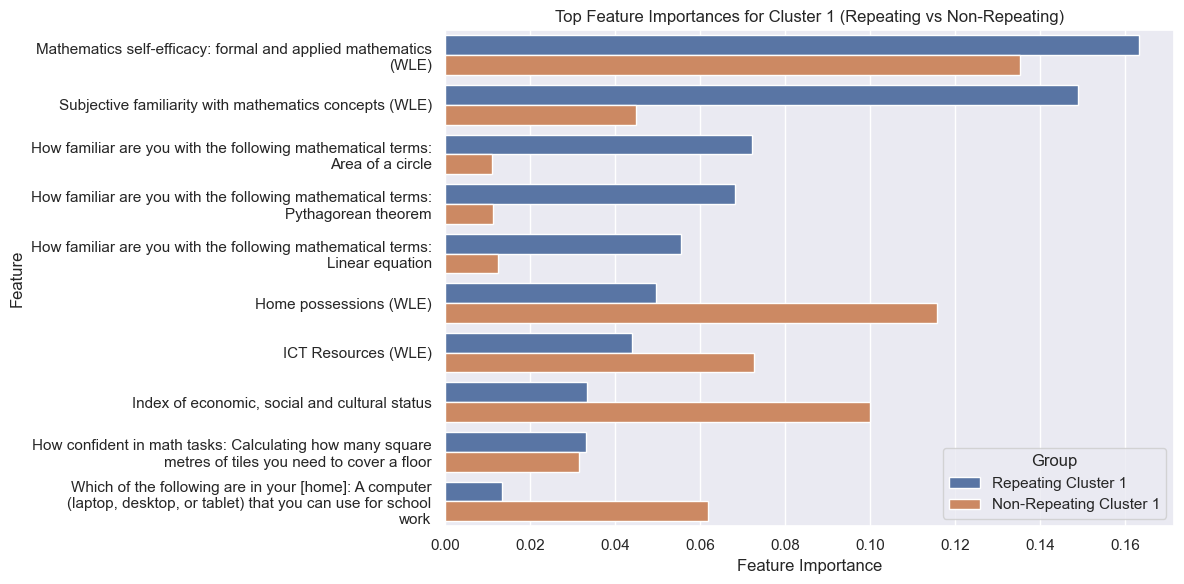

In [14]:
# Cluster 1

X_1_repeating = X_encoded_repeating.copy()
X_1_repeating["cluster_1"] = (X_1_repeating["kmeans"] == 1).astype(int)

X_rep = X_1_repeating.drop(columns=["kmeans", "cluster_1"])
y_rep = X_1_repeating["cluster_1"]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_1_not_repeating = X_encoded_not_repeating.copy()
X_1_not_repeating["cluster_1"] = (X_1_not_repeating["kmeans"] == 1).astype(int)

X_nonrep = X_1_not_repeating.drop(columns=["kmeans", "cluster_1"])
y_nonrep = X_1_not_repeating["cluster_1"]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 1": importances_rep,
        "Non-Repeating Cluster 1": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)
importance_df = importance_df.loc[top_features]

importance_df = importance_df.sort_values(by="Repeating Cluster 1", ascending=False)

plot_feature_importances(importance_df, cluster_id=1)

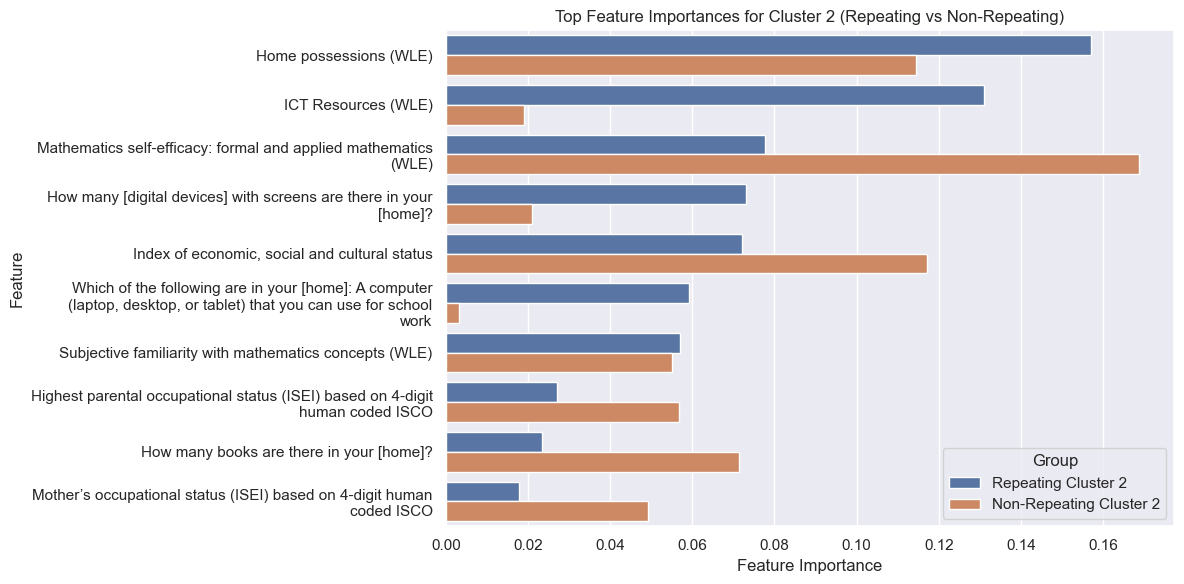

In [15]:
# Cluster 2
cluster = "cluster_2"

X_2_repeating = X_encoded_repeating.copy()
X_2_repeating[cluster] = (X_2_repeating["kmeans"] == 2).astype(int)

X_rep = X_2_repeating.drop(columns=["kmeans", cluster])
y_rep = X_2_repeating[cluster]

model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_rep, y_rep)

importances_rep = pd.Series(model_rep.feature_importances_, index=X_rep.columns)

X_2_not_repeating = X_encoded_not_repeating.copy()
X_2_not_repeating[cluster] = (X_2_not_repeating["kmeans"] == 2).astype(int)

X_nonrep = X_2_not_repeating.drop(columns=["kmeans", cluster])
y_nonrep = X_2_not_repeating[cluster]

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_nonrep, y_nonrep)

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_, index=X_nonrep.columns
)

importance_df = pd.DataFrame(
    {
        "Repeating Cluster 2": importances_rep,
        "Non-Repeating Cluster 2": importances_nonrep,
    }
)

top_features = (
    (importances_rep.abs() + importances_nonrep.abs())
    .sort_values(ascending=False)
    .head(10)
    .index
)

importance_df = importance_df.loc[top_features]
importance_df = importance_df.sort_values(by="Repeating Cluster 2", ascending=False)

plot_feature_importances(importance_df, cluster_id=2)

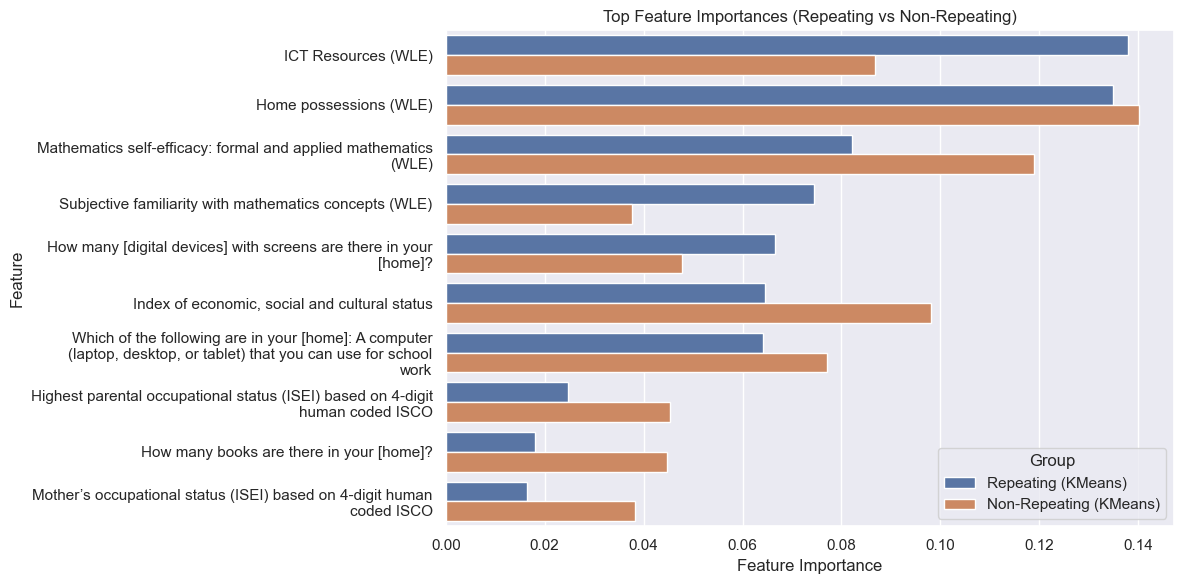

In [22]:
model_rep = RandomForestClassifier(random_state=42)
model_rep.fit(X_encoded_repeating.drop(columns=["kmeans"]), X_encoded_repeating["kmeans"])

importances_rep = pd.Series(
    model_rep.feature_importances_,
    index=X_encoded_repeating.drop(columns=["kmeans"]).columns,
)

model_nonrep = RandomForestClassifier(random_state=42)
model_nonrep.fit(X_encoded_not_repeating.drop(columns=["kmeans"]), X_encoded_not_repeating["kmeans"])

importances_nonrep = pd.Series(
    model_nonrep.feature_importances_,
    index=X_encoded_not_repeating.drop(columns=["kmeans"]).columns,
)

importance_all = pd.DataFrame({
    "Repeating (KMeans)": importances_rep,
    "Non-Repeating (KMeans)": importances_nonrep
})

top_features = (importances_rep.abs() + importances_nonrep.abs()).sort_values(ascending=False).head(10).index

importance_all = importance_all.loc[top_features]
importance_all = importance_all.sort_values(by="Repeating (KMeans)", ascending=False)

plot_feature_importances(importance_all, mapping=column_mapping)

In [17]:
silhouette_repeating = silhouette_score(
    X_encoded_repeating.drop(columns="kmeans"), kmeans_repeating.labels_
)
# silhouette_not_repeating = silhouette_score(
#     X_encoded_not_repeating.drop(columns="kmeans"), kmeans_not_repeating.labels_
# )

print(f"Silhouette Score (Repeating): {silhouette_repeating:.3f}")
# print(f"Silhouette Score (Non-Repeating): {silhouette_not_repeating:.3f}")

Silhouette Score (Repeating): 0.113
